## Integrating all the 3 models to create the pipeline

Run the sections below before progressing onto the fourth section where you can interact with the pipeline. The models are stored in a publically accessible google drive and the environment needs to be established (loading embeddings and such) before the results can be produced. The models are stored in [this drive folder](https://drive.google.com/drive/folders/1M5d__udAP3aB0JBcGTsaREcFzMJZV-Sc?usp=share_link) and the shared folders need to be present in the drive to achieve real-time results.

In [ ]:
#connecting folder that has files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Running all prerequisites
This block is subdivided to load components of all 3 pipeline components but it can simple be run in its entirety without expansion as well.

### Comp 1 loading

Comp 1 is a biderectional LSTM Model the code for which can be found [here.](https://github.com/harshitaachadha/Recurrent-Rhapsody/blob/main/Comp1/comp1_VF.ipynb) Open this in google colab using - <a target="_blank" href="https://colab.research.google.com/github/harshitaachadha/Recurrent-Rhapsody/blob/main/Comp1/comp1_VF.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
#loading the model and saved corpus
from keras.models import load_model
import pickle
model_comp1 = load_model('/content/drive/MyDrive/CSCI6364Proj/only_four_model_finalV2.h5')
with open('/content/drive/MyDrive/CSCI6364Proj/tokenizer-VF2.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
def complete_this_song(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=856, padding='pre')
        predict_x=model_comp1.predict(token_list, verbose=0) 
        predicted=np.argmax(predict_x,axis=1)
        
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

### Comp 2 loading

Comp 2 is made up of S-BERT embedding generation model + cosine similarity function to identify priming sequence from amongst the known MIDI files for complementary backing track generation. The training notebook for this can be found [here.](https://github.com/harshitaachadha/Recurrent-Rhapsody/blob/main/Comp2/Comp2_VF.ipynb) Open this in google colab using - <a target="_blank" href="https://colab.research.google.com/github/harshitaachadha/Recurrent-Rhapsody/blob/main/Comp2/Comp2_VF.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
#load the model
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
model_comp2 = SentenceTransformer('bert-base-nli-mean-tokens')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#load the embedding files
import pickle
with open('/content/drive/MyDrive/CSCI6364Proj/embeddingscomp2VF.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_sentences = stored_data['sentences']
    stored_embeddings = stored_data['embeddings']

In [ ]:
def get_actual_seq_list(match_list):    
  df = pd.read_csv('/content/drive/MyDrive/CSCI6364Proj/prim_exist.csv')
  for item in match_list:
    if not df.loc[df['track_id'] == item[1]].empty:
      ans = df.loc[df['track_id'] == item[1]]['prim_seq']
    else:
      continue
  return ans

def get_num_seq(pstring):
  pstring = pstring.replace("[", "").replace("]", "")
  string_list = pstring.split(', ')
  int_list = [int(x) for x in string_list]
  req=[]
  i=0
  for item in int_list:
    if item<=315:
      req.append(item)
      i=i+1
      if len(req)>=10:
        return req
    else:
      continue


In [ ]:
#function to give the most similar song - 
#to calculate similarity
from sklearn.metrics.pairwise import cosine_similarity
#for getting three most similar songs
import heapq
import csv
def get_priming_seq(text, embeddings):
  tok = model_comp2.encode(text)
  ans = cosine_similarity([tok],embeddings)
  sim_list = ans[0]
  #loading all available track id's
  file = open("/content/drive/MyDrive/CSCI6364Proj/t_list.csv", "r")
  data = list(csv.reader(file, delimiter=","))
  t_list = data[0]
  file.close()
  result = heapq.nlargest(len(t_list), zip(sim_list,t_list))
  prim_string = get_actual_seq_list(result)
  prim_seq = get_num_seq(prim_string.values[0])
  return prim_seq

### Comp 3 loading

Comp 3 is a single instrument RNN model where the back track generation problem is posed as the next note generation problem. The training notebook for this can be found [here.](https://github.com/harshitaachadha/Recurrent-Rhapsody/blob/main/comp3/Comp3_VF.ipynb) Open this in google colab using - <a target="_blank" href="https://colab.research.google.com/github/harshitaachadha/Recurrent-Rhapsody/blob/main/comp3/Comp3_VF.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
import os
import shutil
import glob
import numpy as np 
import pandas as pd
!pip install pretty_midi
import pretty_midi
!pip install pypianoroll
import pypianoroll
import tables
from music21 import converter, instrument, note, chord, stream
import music21
import librosa
#import librosa.display
import matplotlib.pyplot as plt
from keras.utils import np_utils
import json
import IPython.display
from datetime import datetime
import random

import torch
import torch.nn as nn
from torch.nn import functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from tqdm.notebook import tqdm, trange

import random
import itertools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [ ]:
with open('/content/drive/MyDrive/CSCI6364Proj/notes_initial_train.json', 'r') as outfile:
  notes_train = json.load(outfile)
# Prepare input and output sequences

def prepare_sequences(notes, note_to_int = None, sequence_length = 32):
  network_input = []
  network_output = []

  if not note_to_int:
    # Set of note/chords (collapse into list)
    pitch_names = sorted(set(itertools.chain(*notes)))
    # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitch_names))

  # Loop through all songs
  for song in notes:
    # Check for the end
    i = 0
    while i + sequence_length < len(song):
      # seq_len notes for the input seq
      sequence_in = song[i: i + sequence_length]
      # Next note to predict
      sequence_out = song[i+sequence_length]
      # Return the int representation of the note - *(If note not found)
      network_input.append([note_to_int.get(char, 0) for char in sequence_in])
      network_output.append(note_to_int.get(sequence_out, 0))
      i += sequence_length

  n_patterns = len(network_input)

  # Reshape for LSTM input
  network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
  # Normalize input (?? - CHECK LATER - this assumes the alphabetical order of the notes carries semantic meaning?)
  #network_input = network_input / len(pitch_names)
  #network_output = np_utils.to_categorical(network_output)

  return network_input, network_output, note_to_int

train_input, train_output, note_to_int = prepare_sequences(notes_train, sequence_length = 64)
#test_input, test_output, _ = prepare_sequences(notes_test, note_to_int = note_to_int, sequence_length = 64)

In [ ]:
class GenerationRNN(nn.Module):
  # input_size: number of possible pitches
  # hidden_size: embedding size of each pitch
  # output_size: number of possible pitches (probability distribution)
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(GenerationRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size * n_layers, output_size)
    
    def forward(self, input, hidden):
        # Creates embedding of the input texts
        #print('initial input', input.size())
        input = self.embedding(input.view(1, -1))
        #print('input after embedding', input.size())
        output, hidden = self.gru(input, hidden)
        #print('output after gru', output.size())
        #print('hidden after gru', hidden.size())
        output = self.decoder(hidden.view(1, -1))
        #print('output after decoder', output.size())
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size).to(device)

In [ ]:
n_pitches = len(note_to_int)
hidden_size = 96
n_layers = 2
n_epochs = 40
lr = 0.002
lr_lambda = 0.99
model_comp3 = GenerationRNN(input_size = n_pitches, hidden_size = hidden_size, output_size = n_pitches, n_layers = n_layers).to(device)
model_comp3.load_state_dict(torch.load('/content/drive/MyDrive/CSCI6364Proj/Comp3_RNN_29APR'))

<All keys matched successfully>

In [ ]:
# generate new music
def evaluate(net, prime_seq, predict_len):
    '''
    Arguments:
    prime_seq - priming sequence (converted t)
    predict_len - number of notes to predict for after prime sequence
    '''
    hidden = net.init_hidden()

    predicted = prime_seq.copy()
    prime_seq = torch.tensor(prime_seq, dtype = torch.long).to(device)


    # "Building up" the hidden state using the prime sequence
    for p in range(len(prime_seq) - 1):
        input = prime_seq[p]
        _, hidden = net(input, hidden)
    
    # Last character of prime sequence
    input = prime_seq[-1]
    
    # For every index to predict
    for p in range(predict_len):

        # Pass the inputs to the model - output has dimension n_pitches - scores for each of the possible characters
        output, hidden = net(input, hidden)

        # Pick the character with the highest probability 
        predicted_id = torch.argmax(torch.softmax(output, dim = 1))

        # Add predicted index to the list and use as next input
        predicted.append(predicted_id.item()) 
        input = predicted_id

    return predicted

In [ ]:
def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    return midi_stream

In [ ]:
!apt install fluidsynth
!pip install midi2audio

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (2.1.1-2).
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [263]:
from music21 import *
from midi2audio import FluidSynth
from IPython.display import Audio, Image
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

### Generating output - Code

In [258]:
def generate_a_recurrent_rhapsody():
  user_input = input("Please enter some words as prompt for the model pipeline - ")
  print("Component 1: Generate the lyrics initializing")
  lyrics = complete_this_song(user_input, 180)
  lyrics = add_newlines(lyrics)
  print("Lyrics have now been generated!")
  print("Component 2: Lookup priming sequence initializing")
  matched_priming = get_priming_seq(lyrics, stored_embeddings)
  print("A priming sequence has now been identified!")
  print("Component 3: Generate a backing track initializing")
  generated_seq = evaluate(model_comp3, matched_priming, predict_len = 100)
  # Convert the generated ints into notes
  int_to_note = {number:note for note, number in note_to_int.items()}
  generated_seq = [int_to_note[e] for e in generated_seq]
  print("Backing track generated successfully!")
  print("Your unique lyric and backing track combination is - ")
  song_image = My_song(lyrics)
  display(song_image)
  #converting nodes to midi strea,
  generated_stream = create_midi(generated_seq)
  stream_obj = generated_stream
  midi_file = midi.translate.streamToMidiFile(stream_obj)
  midi_file.open('output.mid', 'wb')
  midi_file.write()
  midi_file.close()
  FluidSynth().midi_to_audio('output.mid', 'output.wav')
  audio = Audio('output.wav')
  display(audio)
  print("Now its your turn to take it away!")


In [266]:
def add_newlines(text):
    words = text.split()
    new_text = ""
    counter = 0
    for i, word in enumerate(words):
        new_text += word + " "
        counter += 1
        if counter == 10:
            new_text += "\n"
            counter = 0
            if i % 40 == 0 and i > 0:
                new_text += "\n\n"
    return new_text.strip()

In [265]:
def My_song(song):
    img = Image.open("/content/drive/MyDrive/CSCI6364Proj/bg.png")
    Text_on_image = ImageDraw.Draw(img)
    font = ImageFont.truetype("/content/drive/MyDrive/CSCI6364Proj/Aller_It.ttf", 36)
    Text_on_image.text((450,90), song,font =font, fill =(0, 0, 0))
    return img  

## Try it yourself!

Please enter some words as prompt for the model pipeline - i hate my life
Component 1: Generate the lyrics initializing
Lyrics have now been generated!
Component 2: Lookup priming sequence initializing
A priming sequence has now been identified!
Component 3: Generate a backing track initializing
Backing track generated successfully!
Your unique lyric and backing track combination is - 


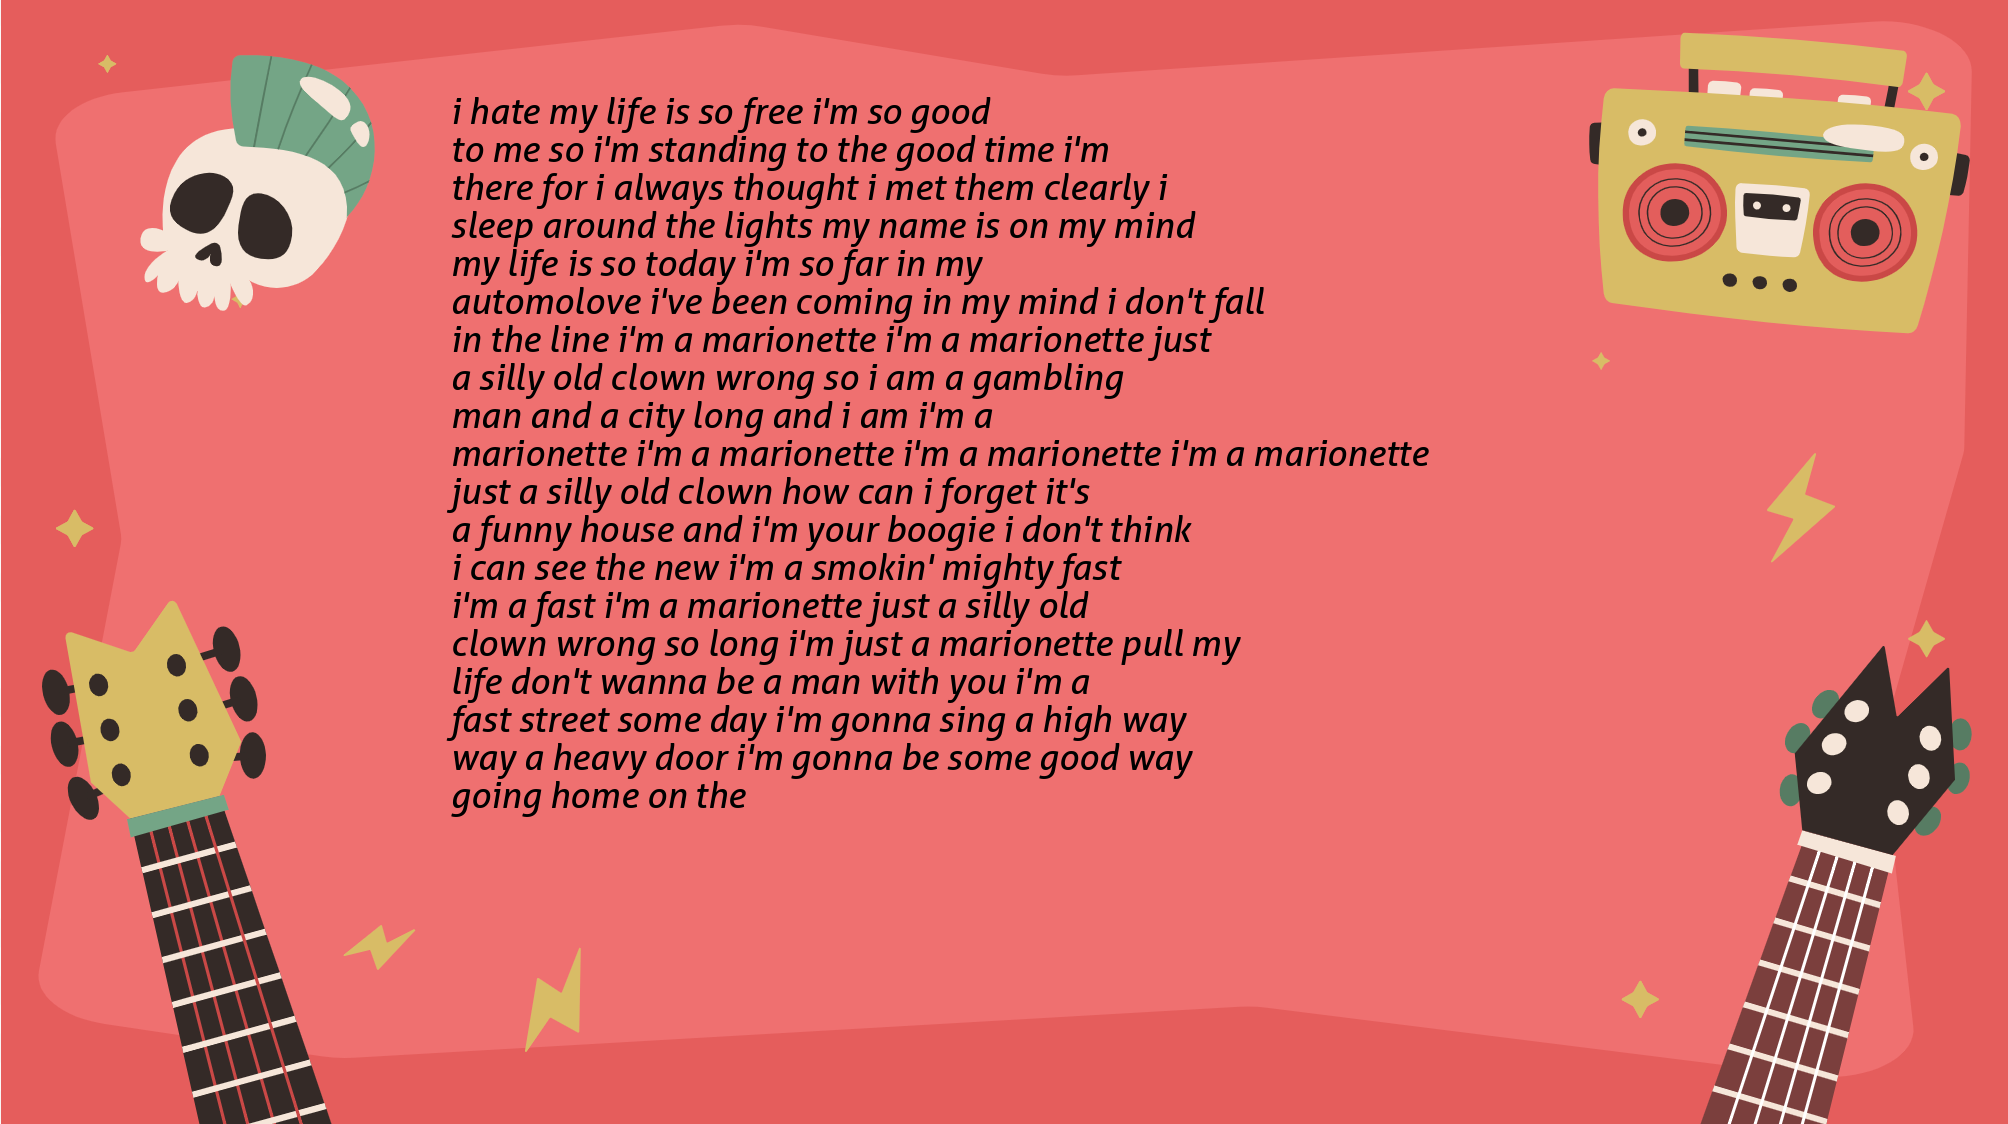

Now its your turn to take it away!


In [267]:
generate_a_recurrent_rhapsody()